In [1]:
from datetime import datetime, timedelta
import os
import time
import requests
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
import keras as kr
import glob

C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Open

In [2]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'wait':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [3]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [4]:
aba = main.Abathor('LTC-USD')

In [5]:
def save_observations(observations):
    for i, df in enumerate( observations):
        dire = os.getcwd() + '\\data\\{}.pkl'.format(i)
        df.to_pickle(dire)

In [6]:
def load_observations():
    observations = []
    os.chdir('data')
    for file in glob.glob('*.pkl'):
        observations.append(pd.read_pickle(file))
    os.chdir('..')
    return observations

In [7]:
observations = load_observations()
save_observations(observations)

In [8]:
def get_random_candles(seconds = 60.00):
    days = np.random.randint(1, 500)
    hours = np.random.randint(0, 12)
    minutes = np.random.randint(0,60)
    start = datetime.today() - timedelta(days = days, hours = hours, minutes = minutes )
    end = start + timedelta(seconds = seconds * 200)
    cans =  aba.get_candles(start, end, granularity = seconds)
    observations.append(cans)
    save_observations(observations)
    return cans

In [9]:
#to_download = 100
#bar = rt.progress_bar(to_download)
#for num in range(0, to_download):
#    get_random_candles()
#    bar.progress()

In [10]:
def make_changes(candles):
    changes = candles.copy()
    candles['minutes'] = (candles.index - candles.index.min()).seconds / 60
    standard_open = changes.loc[changes.index.min(), 'open']
    standard_volume = changes.loc[changes.index.min(), 'volume']
    changes[['low', 'high', 'open', 'close']] = changes[['low', 'high', 'open', 'close']]/standard_open
    changes['volume']  = changes['volume']/changes['volume']
    #changes[['low', 'high', 'open', 'close', 'volume']] = np.log(changes[['low', 'high', 'open', 'close', 'volume']]).diff().bfill()
    changes['minutes'] = candles['minutes']
    return changes
def create_data(candle_list, candles_before = 10):
    X = []
    y = []
    ar = np.array
    bar = rt.progress_bar(len(candle_list))
    for candles in candle_list:
        bar.progress()
        changes = make_changes(candles)

        for index in changes.index:
            change_percent = changes.loc[index, 'close']
            all_before = changes.loc[:index]
            amount = len(all_before)
            if amount > candles_before + 2:
                Xi = all_before.iloc[amount - (candles_before+ 2):amount-2]
                Xi = ar(Xi[['low', 'high', 'open', 'close', 'volume', 'minutes']].values)
                X.append(Xi)
                y.append(change_percent)
    X, y =  ar(X), ar(y)
    
    #temp = pd.DataFrame(y, columns = ['y'])
    #mask = temp['y'] >= 0.005
    #temp.loc[mask, 'new_y'] = 1
    #temp.loc[~mask, 'new_y'] = 0
    #y = temp['new_y'].values
    
    return X, y
    

In [11]:
def make_samples_even(X,y, target_ratio = .8 ):
    X = list(X)
    y = list(y)
    
    def get_ratio(y):
        total = len(y)
        wins = np.sum(y)
        losses = total - wins
        return wins/losses
    
    def add_another(X, y, windexes):
        to_add = np.random.choice(windexes)
        X.append(X[to_add])
        y.append(y[to_add])
    ratio = get_ratio(y)
    
    while ratio < target_ratio:
        windexes = [i for i,val in enumerate(y) if val==1]
        for num in range(0, 500):
            add_another(X, y, windexes)

        ratio = get_ratio(y)
        print(ratio)
        clear_output(True)
        
         
    return np.array(X), np.array(y)


In [12]:
observations = load_observations()

In [13]:
candles_before = 25
X, y = create_data(observations, candles_before)


0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 679 Remaining: 1, Remaining Time: 0s


In [14]:
#y.sum()/len(y)

In [15]:
#X,y  = make_samples_even(X, y, 1 )

In [33]:
def generate_model(X, y):
    model = kr.models.Sequential()
    model.add(kr.layers.LSTM(2**4, input_shape=X.shape[1:],return_sequences=False))
    #model.add(kr.layers.Dropout(0.05))
    model.add(kr.layers.Dense(2**8))
    model.add(kr.layers.Dense(1))
    #model.add(kr.layers.Activation('sigmoid'))
    #optimizer = kr.optimizers.RMSprop(lr=0.001)
    optimizer = kr.optimizers.Adam(0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

model = generate_model(X, y)

In [17]:
model.fit(X[:10], y[:10])

Epoch 1/1
10/10 [==============================] - 1s 55ms/step - loss: 1.3296


In [34]:
def download_hidden_list(samples = 10):
    hidden_list = []
    bar = rt.progress_bar(samples)
    for num in range(0, samples):
        bar.progress()
        hidden_list.append(get_random_candles(60))
        
    X, y = create_data(hidden_list, candles_before)

    return X, y

In [19]:
hidden_x, hidden_y = download_hidden_list(30)

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0>    | 100.00 % 
Done: 29 Remaining: 1, Remaining Time: 0s


In [35]:
def fit(X, y, epochs = 1, hidden_x = False, hidden_y = False):
    if type(hidden_x) == type(False):
        hidden_x, hidden_y = download_hidden_list(10)
    
    for num in range(epochs):
        model.fit(X, y,batch_size=1000,  epochs=5, verbose = 1)
        test_loss = model.evaluate(hidden_x, hidden_y)
        if test_loss < 0.001:
            return 
        print('{} Testing Loss: '.format(num), test_loss)

In [ ]:
fit( X, y, 100, hidden_x,hidden_y )

Epoch 1/5
103009/103009 [==============================] - 3s 29us/step - loss: 0.0757
Epoch 2/5
103009/103009 [==============================] - 2s 23us/step - loss: 0.0181
Epoch 3/5
103009/103009 [==============================] - 2s 23us/step - loss: 0.0175
Epoch 4/5
103009/103009 [==============================] - 2s 22us/step - loss: 0.0217
Epoch 5/5
3662/3662 [==============================] - 0s 65us/step
0 Testing Loss:  0.022163683666574507
Epoch 1/5
103009/103009 [==============================] - 2s 23us/step - loss: 0.0185
Epoch 2/5
 40000/103009 [==========>...................] - ETA: 1s - loss: 0.0174

In [22]:
def evaluate( X = False, y = False):
    if type(X) == type(False):
        X, y = download_hidden_list(10)
    preds = model.predict(X)    
    comparison = pd.DataFrame()
    comparison['preds'] = preds.reshape(len(preds))
    comparison['preds'] = comparison['preds'].apply(lambda x: round(x, 4))
    comparison['y'] = y
    return preds, comparison

preds, comparison = evaluate(hidden_x, hidden_y)

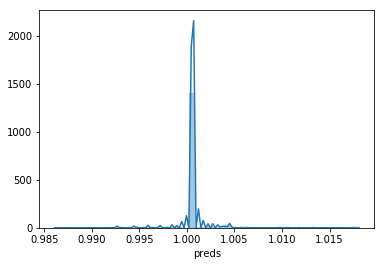

In [23]:
sea.distplot(comparison['preds'])
plt.show()

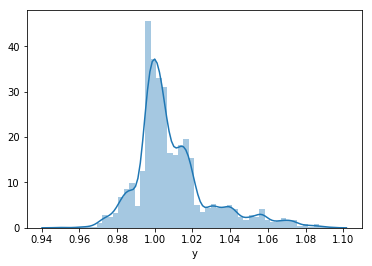

In [24]:
sea.distplot(comparison['y'])
plt.show()

In [25]:
comparison['status'] = 'None'
mask = (comparison['preds'] == 0) & (comparison['y'] == 0)
comparison.loc[mask, 'status'] = '0'

mask = (comparison['preds'] > 0) & (comparison['y'] > 0)
comparison.loc[mask, 'status'] = '-'

mask = (comparison['preds'] < 0) & (comparison['y'] < 0)
comparison.loc[mask, 'status'] = '+'

In [26]:
comparison['wrong'] = comparison['y'] - comparison['preds']

In [27]:
comparison['wrong'].median()

0.0034254237288136036

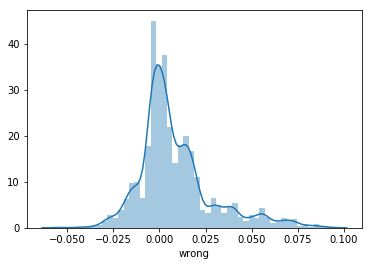

In [28]:
sea.distplot(comparison['wrong'])
plt.show()

In [29]:
def predict_next_move( seconds = 60.00):
    end = datetime.today()
    start = end - timedelta(seconds = seconds * 200)
    cans =  aba.get_candles(start, end, granularity = seconds)
    return cans


In [30]:
cans = predict_next_move(60)
chartio(cans = cans, count = 30)
changes = make_changes(cans)
changes = changes.iloc[-candles_before:][['low', 'high', 'open', 'close', 'volume', 'minutes']]
changes = changes.values.reshape((1, changes.shape[0], changes.shape[1]))
changes = changes/
print('Prediction:',model.predict(changes)[0][0])
cans.loc[cans.index.max()].apply(lambda x: '{:.2f}'.format(x))

SyntaxError: invalid syntax (<ipython-input-30-9865dfe25005>, line 6)